# In this notbeook threse is an application of the CrossCorrelation module



In [1]:
root_folder = '/media/DATA/jbonato/astro_segm'

In [2]:

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import glob

#import os
from skimage import io
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

import sys
sys.path.insert(0,root_folder+'/RASTA/modules/')
from CC import main_CC,clean_outer_pixel,cleanCC_for_signals
from get_traces import Extr_miniROI,get_signal,get_signals
from gui_results import layout


MAX_ROI_AREA_PROC=80
MU_PX = 1

## Rocording loading


In [3]:
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num = '0137'
query = '{0:0>3}'.format(num)
dict_im = pickle.load( open( "inference_ex.pkl", "rb" ))
stack_o =  io.imread('/media/DATA/jbonato/astro_segm/set6/0137/TSeries-11182021-1331-1340_Ch2__movie_corrected_aligned.tiff').astype(np.uint16)[:6000,:,:]#dict_im['t-series_'+query]
dict_im['t-series_'+query] = stack_o
mask_sp = dict_im['Single_cell_mask_'+query]
T,N,M = stack_o.shape
###
print('t-series loaded, dim: ',stack_o.shape)
print('roi loaded, dim: ',mask_sp.shape)


#### remove outer pixels
mask_sp = clean_outer_pixel(mask_sp,num_pix=4)


t-series loaded, dim:  (6000, 512, 512)
roi loaded, dim:  (24, 512, 512, 2)


In [4]:
plot_video = False
if plot_video:
    im_list = []
    for i in range(100):
        im_list.append(stack_o[i,:,:])

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(i, animated=True)] for i in im_list]

    ani = animation.ArtistAnimation(fig, ims, interval=1, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from get_traces import allineate_stack
import time

@torch.no_grad()
def corr_mask(roi_proc,crop_stack,device,th_corr,nf_mFilter=21):#5
    ##tensor definition
    roi_num,N,M = roi_proc.shape
    map_ = torch.from_numpy(np.uint8(roi_proc.reshape(roi_num,N*M)))
#    print(np.sum(roi_proc[0,:,:]),np.sum(roi_proc[1,:,:]),torch.sum(map_[0,:]),)
    crop_stack = crop_stack.reshape(crop_stack.shape[0],N*M)
    crop_ten = torch.from_numpy(crop_stack.T).float()
    pix_crop,T = crop_ten.size()


    #load to device
    map_ = map_.reshape(roi_num,pix_crop,1,1).to(device)
    crop_ten = crop_ten.reshape(pix_crop,1,T).to(device)
    #convolution

    filter_ = (1/nf_mFilter)*torch.ones((1,1,nf_mFilter),dtype=torch.float).to(device)
    crop_ten = F.conv1d(crop_ten,filter_,padding=(nf_mFilter-1)//2)
    #initialize tensor
    map_to_cover = torch.empty((pix_crop,1,1),dtype = torch.uint8).to(device)

    coor_pix_ten = torch.zeros((roi_num,N,M),dtype=torch.float).to(device)
    #loop over rois
    for j in range(roi_num):

        map_to_cover = map_[j,:,:,:]
        el_test = torch.sum(map_to_cover)
        if el_test!=0:
            test_ten = torch.empty((int(el_test),1,T),dtype=torch.float).to(device)
            #get test pixels and normalize it for correlation
            test_ten = torch.masked_select(crop_ten, map_to_cover.bool()).reshape(el_test,1,T)

            test_ten = (test_ten-torch.mean(test_ten,dim=2).reshape(el_test,1,1))/(0.0001+torch.std(test_ten,dim=2).reshape(el_test,1,1)*T)

            #normalize pixel for correlation
            crop_ten = (crop_ten - torch.mean(crop_ten,dim=2).reshape(pix_crop,1,1))/(0.0001+torch.std(crop_ten,dim=2).reshape(pix_crop,1,1))

            #compute correlation 
      #      print('SIZE crop_ten:',crop_ten.size(),'test_ten',test_ten.size())
            cycles = (el_test.float()/500).floor()
            cyc=0
            starting = 500
            #print('CYCLES',cycles)
            while(cyc<=cycles):
                #print('safty check',cyc,cycles)
                if cyc<cycles :
                    buff2 = F.conv1d(crop_ten,test_ten[starting*cyc:starting*cyc+starting,:,:],padding=10)
                    cyc+=1
                else:
                    buff2 = F.conv1d(crop_ten,test_ten[starting*cyc:,:,:],padding=10)
                    cyc+=1

                buff2[buff2<th_corr]=0
                buff2 =torch.sum(buff2.float(),dim=2)
                buff2 =torch.sum(buff2,dim=1)
                buff2 = buff2.reshape(N,M)
                buff2[buff2>0]=1
                coor_pix_ten[j,:,:] =coor_pix_ten[j,:,:]+ buff2.float()
            
    del crop_ten, map_,map_to_cover, test_ten,buff2

    return coor_pix_ten



class comp_err_correlation():
    
    def __init__(self,coord_st_l,coord_cir_l,stack,mask_test,radius=45,nf_mFilter=5):
        self.coord_st_l = coord_st_l
        self.coord_cir_l = coord_cir_l
        self.stack = stack
        self.mask_test = mask_test
        self.T,_,_ = stack.shape
        self.radius = radius
        self.nf_mFilter = nf_mFilter
        
    def gen_false(self,stack,coord_cir_l,rm_px = 6):
        _,N,M = stack.shape
        rnd_mask = np.zeros((N,M))
        ref = np.ones((N,M))
        for j in range(len(coord_cir_l)):
            coord_c = coord_cir_l[j]
            ref[coord_c[0],coord_c[1]]=0
        ref[0:rm_px,:]=0
        ref[-rm_px:,:]=0
        ref[:,0:rm_px]=0
        ref[:,-rm_px:]=0
        coord_false = np.where(ref==1)
        #print("qwqwq",len(coord_false[0]))
        coord_rnd = np.random.choice(len(coord_false[0]), 1000, replace=False)

        rnd_mask[coord_false[0][coord_rnd],coord_false[1][coord_rnd]]=1
        #plt.imshow(rnd_mask)
        coord_out = np.where(rnd_mask==1)
        return stack[:,coord_false[0][coord_rnd],coord_false[1][coord_rnd]]

    def coor_false_discovery(self,roi,crop_stack,false_stack,device):
            T,N,M = crop_stack.shape
            _,N_f = false_stack.shape
            roi = roi.reshape(-1)
            coord_roi = np.where(roi==1)
            crop_stack = crop_stack.reshape(T,N*M)

            roi_stack = np.empty((T,len(coord_roi[0])))
            roi_stack = crop_stack[:,coord_roi[0]].astype(np.float32)

            map_ = torch.from_numpy(roi_stack.T).float()
            false_ten = torch.from_numpy(false_stack.T.astype(np.float32)).float()


            #load to device
            map_ = map_.reshape(len(coord_roi[0]),1,T).to(device)

            false_ten = false_ten.reshape(N_f,1,T).to(device)
           #convolution

            filter_ = (1/self.nf_mFilter)*torch.ones((1,1,self.nf_mFilter),dtype=torch.float).to(device)
            map_ = F.conv1d(map_,filter_,padding=(self.nf_mFilter-1)//2)
            false_ten = F.conv1d(false_ten,filter_,padding=(self.nf_mFilter-1)//2)

           #initialize tensor

            #normalize pixel for correlation
            map_ = (map_-torch.mean(map_,dim=2).reshape(len(coord_roi[0]),1,1))/((torch.std(map_,dim=2).reshape(len(coord_roi[0]),1,1)*T)+0.001)
            false_ten = (false_ten - torch.mean(false_ten,dim=2).reshape(N_f,1,1))/((torch.std(false_ten,dim=2).reshape(N_f,1,1))+0.001)


            buff = F.conv1d(map_,false_ten,padding=5)

            return buff.data.cpu().numpy()
    
    def find_threshold(self):
           
        th_corr=0.85
       
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        ind_list=0
        ind_list_red=0
        
        th_list=[0.85,0.88,0.9,0.91,0.92,0.93,0.94,0.95]
        th_corr=th_list[0]
        th_list_red=[0.85,0.80,0.75,0.65,0.60,0.55,0.45,0.40]
      
        flag_red = True
        flag=True
        
        list_corr = []
        for iter_ in range(20):
            print('ITER: ',iter_)
            list_cell = []
            for j in range(len( self.coord_st_l)):

                coord_bb = self.coord_st_l[j]
                coord_circonf = self.coord_cir_l[j]

                stack_crop = np.empty((self.T,self.radius*2,self.radius*2))
                stack_crop = self.stack[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]].copy()



                mask_crop = np.sum(self.mask_test[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],:],axis=2)
                mask_crop[mask_crop>1]=1

                f_stack = self.gen_false(self.stack,self.coord_cir_l)
                corr_vect = self.coor_false_discovery(mask_crop,stack_crop,f_stack,device)
                max_ = np.amax(corr_vect,axis=2)
                max_ = np.amax(max_,axis=0)
                list_cell.append(max_.copy())
                
            list_corr.append(list_cell)
        print('Ref Corr matrix computed')    
        while( flag and ind_list_red<(len(th_list_red)-1) and ind_list<(len(th_list)-1) ):
            for iter_ in range(20):
                if iter_==0:
                    res_final=0
                res=0
                for j in range(len( self.coord_st_l)):
                    
                    th = list_corr[iter_][j]
                    th[th<th_corr]=0
                    th[th>0]=1
                    #print('tmp',np.sum(th)/1000)
                    res+=(np.sum(th)/1000)

                res/=len(self.coord_st_l) 
                
                res_final+=res
                #print('res_final',res_final)
            res_final/=20

            print('correlation error = {:f} with threshold = {:f}'.format(res_final,th_corr))#res_final,th_corr
            
            if res_final<0.01 and flag_red:
                ind_list_red+=1
                th_corr = th_list_red[ind_list_red]
                if ind_list_red==(len(th_list_red)-1):
                    th_out = th_corr
                    print('Min correlation threshold: ',th_out)
                print('New th',th_corr)
            
            elif res_final<0.06 and res_final>=0.01 and flag_red:
                th_out = th_corr
                flag=False
                print('Reduction finish')
                
            
            if res_final<0.06 and not(flag_red):
                th_out = th_corr
                flag=False
                print('Incr finish')
                
            if res_final>=0.06:
                if flag_red and th_corr!=0.85:
                    flag=False
                    th_out = th_list_red[ind_list_red-1]
                else:
                    ind_list+=1
                    th_corr = th_list[ind_list]
                    if ind_list == len(th_list)-1:
                        th_out = th_corr
                        print('Max correlation threshold: ',th_out)
                    flag_red=False

            
        return th_out
    
    
    
def clean_outer_pixel(astro_roi,num_pix):
    #rem H
    astro_roi[:,:num_pix,:,:]=0
    astro_roi[:,-num_pix:,:,:]=0
    #rem W
    astro_roi[:,:,:num_pix,:]=0
    astro_roi[:,:,-num_pix:,:]=0
    
    return astro_roi

def cleanCC_for_signals(dict_ROI,mask_ROI,MAX_ROI_AREA_PROC):
    _,N,M,_ = mask_ROI.shape
    for key in dict_ROI.keys():
        coord = dict_ROI[key]
        mask_ROI[:,coord[0],coord[1],2]=0
    mask_ROI_clean = np.zeros_like(mask_ROI)
    mask_ROI_clean[:,:,:,:2] = mask_ROI[:,:,:,:2]
    
    mask_ROI_inter_region = np.zeros((N,M))
    
    for i in range(mask_ROI.shape[0]):
        num,comp = cv2.connectedComponents(mask_ROI[i,:,:,2].astype(np.uint8))
        for k in range(1,num):
            pt = np.where(comp==k)
            if pt[0].shape[0]>=(MAX_ROI_AREA_PROC)//2:
                mask_ROI_clean[i,pt[0],pt[1],2]=1
    ### Intersection regions
    mask_ROI_inter_region = np.sum(mask_ROI_clean[:,:,:,2],axis=0)
    mask_ROI_inter_region[mask_ROI_inter_region<=1]=0
    
    for i in range(mask_ROI.shape[0]):
        for j in range(i+1,mask_ROI.shape[0]):
            mask_ROI_clean[i,:,:,2]-=mask_ROI_clean[j,:,:,2]
    
    mask_ROI_clean[mask_ROI_clean<0]=0
    
    return mask_ROI_clean,mask_ROI_inter_region


def main_CC(stack_o,mask_sp,device,r,coord_dict,shift):
    print('radius',r)
    
    print(10*'/','CORR ANALysis',10*'/')
    stack = stack_o.copy()
    T,N,M = stack.shape
    print(stack.flags['C_CONTIGUOUS'])
    
    coord_st_l = []
    coord_cir_l = []
    for j in range(mask_sp.shape[0]):
        name = str(j)
        coord_st_l.append(coord_dict['ST_'+f'{name:0>3}'] )
        coord_cir_l.append(coord_dict['CIRCLE_'+f'{name:0>3}'] )


    err_corr = comp_err_correlation(coord_st_l,coord_cir_l,stack,mask_sp)
    th_corr =err_corr.find_threshold()
    #######################

    mask_out  = np.zeros((mask_sp.shape[0],N,M,3))
    mask_out[:,:,:,:2] = mask_sp
    
    mask_single_corr = np.zeros((len(coord_st_l),2*r,2*r))
    mask_single_corr2 = np.zeros((len(coord_st_l),2*r,2*r))
    t1 = time.time()
    
    for j in range(mask_sp.shape[0]):

        #########################################pick coord
        coord_bb = coord_st_l[j]

        ########################################define buffer
        mask_crop = np.zeros((2,r*2,r*2))
        mask_crop[0,:,:] = mask_sp[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],0]
        mask_crop[1,:,:] = mask_sp[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],1]

        ########################################define stack for cross corr
        stack_crop = np.empty((T,2*r,2*r))
        
        ###to do insert shift corr
        if not(shift is None):
            stack_buffer = allineate_stack(stack,shift['Shift_'+f'{str(j):0>3}'],r_domain=r)
            stack_crop = stack_buffer[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]].copy()
        else:
            stack_crop = stack[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]].copy()
        ###
        
        

        #########################################definr map for selected pixels
        map_ = np.zeros((N,M))
        map_[coord_cir_l[j][0],coord_cir_l[j][1]]=1

        ###### filter the corners from the stack and from buff mask other cell segmentation 
        stack_crop = stack_crop*map_[coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]]


        if np.sum(mask_sp[j,:,:,0])!=0 and np.sum(mask_sp[j,:,:,1])!=0: 

            out_tensor = corr_mask(mask_crop,stack_crop,device,th_corr)
            out_tensor_np = out_tensor[0,:,:].data.cpu().numpy()
            out__ = out_tensor[0,:,:].data.cpu().numpy() + out_tensor[1,:,:].data.cpu().numpy()
            del out_tensor
            torch.cuda.empty_cache()
            out_tensor_np = np.nan_to_num(out_tensor_np)
            out_tensor_np[out_tensor_np>1]=1 
            
            out__ = np.nan_to_num(out__)
            out__[out__>1]=1 
            out__-=np.sum(mask_crop,axis=0)
            mask_out[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],2] += out__#out_tensor_np


            mask_single_corr[j,:,:]=out_tensor_np
            mask_single_corr2[j,:,:]=out__
    print(time.time()-t1)
    mask_out[mask_out>1]=1
    return mask_single_corr2,mask_out


In [6]:
#compute cc analisys
dict_im['shift_ROI_'+query]=None
mask_single_corr,mask_ROI = main_CC(stack_o,mask_sp,device1,dict_im['Astro_domain_radius'],dict_im['crop_coord_ROI_'+query],dict_im['shift_ROI_'+query])

radius 45
////////// CORR ANALysis //////////
True
ITER:  0
ITER:  1
ITER:  2
ITER:  3
ITER:  4
ITER:  5
ITER:  6
ITER:  7
ITER:  8
ITER:  9
ITER:  10
ITER:  11
ITER:  12
ITER:  13
ITER:  14
ITER:  15
ITER:  16
ITER:  17
ITER:  18
ITER:  19
Ref Corr matrix computed
correlation error = 0.000000 with threshold = 0.850000
New th 0.8
correlation error = 0.000000 with threshold = 0.800000
New th 0.75
correlation error = 0.000000 with threshold = 0.750000
New th 0.65
correlation error = 0.000000 with threshold = 0.650000
New th 0.6
correlation error = 0.000000 with threshold = 0.600000
New th 0.55
correlation error = 0.000000 with threshold = 0.550000
New th 0.45
correlation error = 0.000000 with threshold = 0.450000
Min correlation threshold 0.6
New th 0.4


KeyboardInterrupt: 

In [15]:
###clean CC for retrieving signals
mask_ROI,intersection = cleanCC_for_signals(dict_im['ROI_'+query],mask_ROI,MAX_ROI_AREA_PROC)


In [27]:
print("ROI NUM",mask_ROI.shape[0])
dict_roi={}
dict_traces={}
dict_roi_num={}
for s_roi_num in range(mask_ROI.shape[0]):
    if not(dict_im['shift_ROI_'+query] is None):
        shift = dict_im['shift_ROI_'+query]['Shift_'+f'{str(s_roi_num):0>3}']
        stack_buffer = allineate_stack(dict_im['t-series_'+query],shift,r_domain=dict_im['Astro_domain_radius'])
    else:
        stack_buffer = dict_im['t-series_'+query]
    
    print(50*'%','Extracting cell:',s_roi_num)
    constr_split_roi = Extr_miniROI(MAX_ROI_AREA_PROC,MU_PX,mask_ROI[s_roi_num,:,:,2],mask_ROI[s_roi_num,:,:,1],True,dilate_ROI=0)
    arr_out_CC = constr_split_roi.get_miniROI()
    if  s_roi_num==0:
        list_out=arr_out_CC
    else:
        list_out = np.dstack((list_out,arr_out_CC))
    name = str(s_roi_num)
    dict_roi_num['Num_CC_'+f'{name:0>3}']=arr_out_CC.shape[2]
    for area_num in range(arr_out_CC.shape[2]):
        name_area = str(area_num)
        dict_roi['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}'] = np.where(arr_out_CC[:,:,area_num]==1)
        dict_traces['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}']  = get_signal(arr_out_CC[:,:,area_num],stack_buffer)
    print('Extraction: done')

dict_im['Signals_extr_'+query].update(dict_traces) 
dict_im['ROI_'+query].update(dict_roi)

# #### for Visualization purposes
list_out = np.dstack((list_out,dict_im['Final_Mask_'+query][:,:,1:]))
dict_im['Final_Mask_fraction_'+query] = list_out
dict_im['Num_CC_'+query] = dict_roi_num
# #### save dict
pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

ROI NUM 24
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 13
SPLIT DONE (512, 512, 13)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 10
SPLIT DONE (512, 512, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 11
SPLIT DONE (512, 512, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 26
SPLIT DONE (512, 512, 26)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 31
SPLIT DONE (512, 512, 31)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 5
ROIS 17
SPLIT DONE (512, 512, 17)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 6
ROIS 21
SPLIT DONE (512, 512, 21)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 7
ROIS 17
SPLIT DONE (512, 512, 17)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%

## visualization

In [28]:
A = np.sum(dict_im['Final_Mask_fraction_'+query],axis=2)

In [29]:
B = np.concatenate((np.sum(mask_sp,axis=0),A[:,:,np.newaxis]),axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


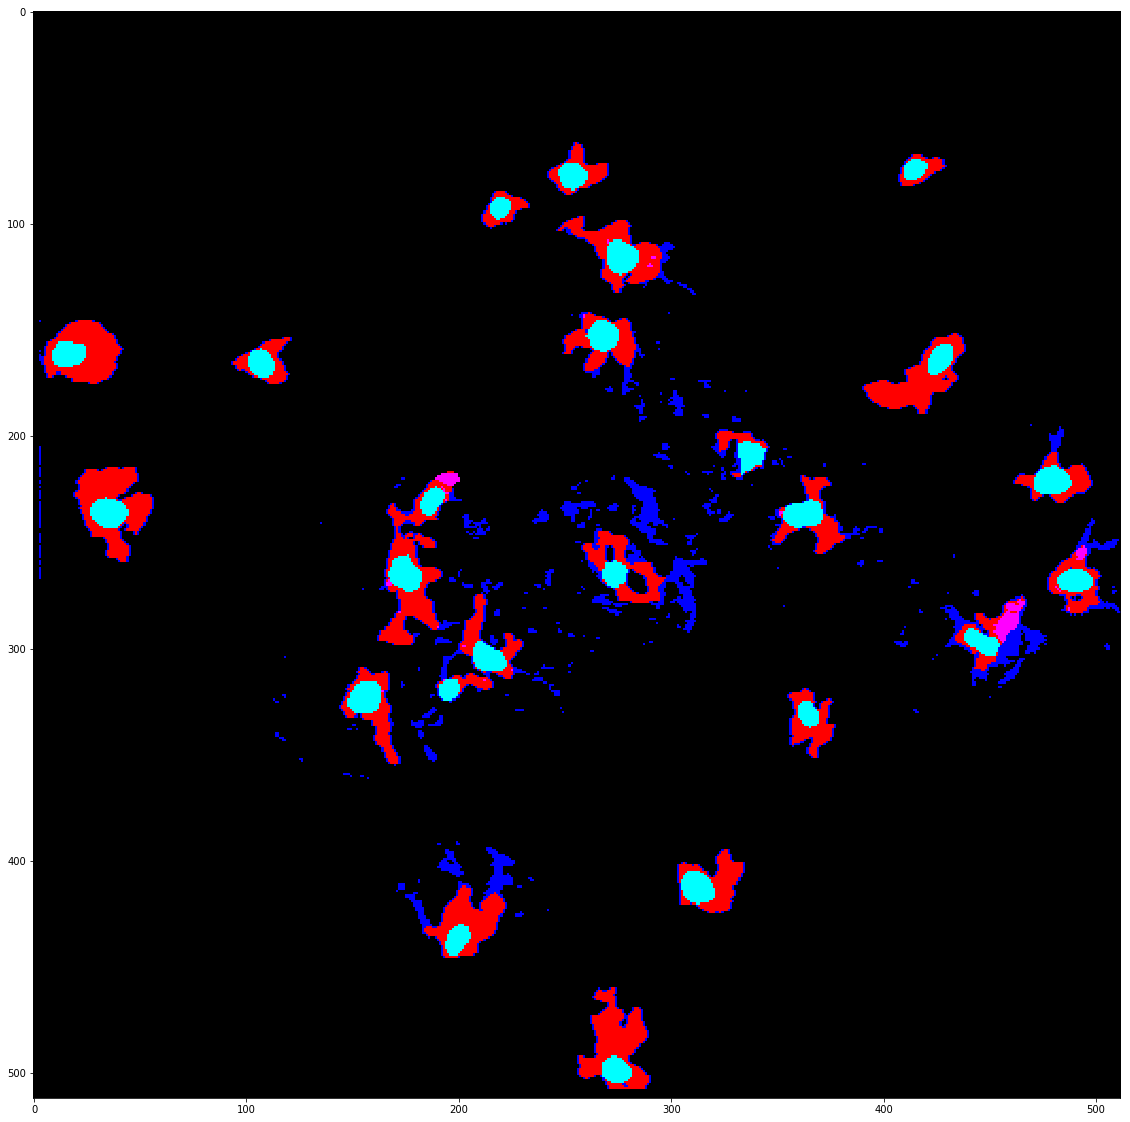

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(B)

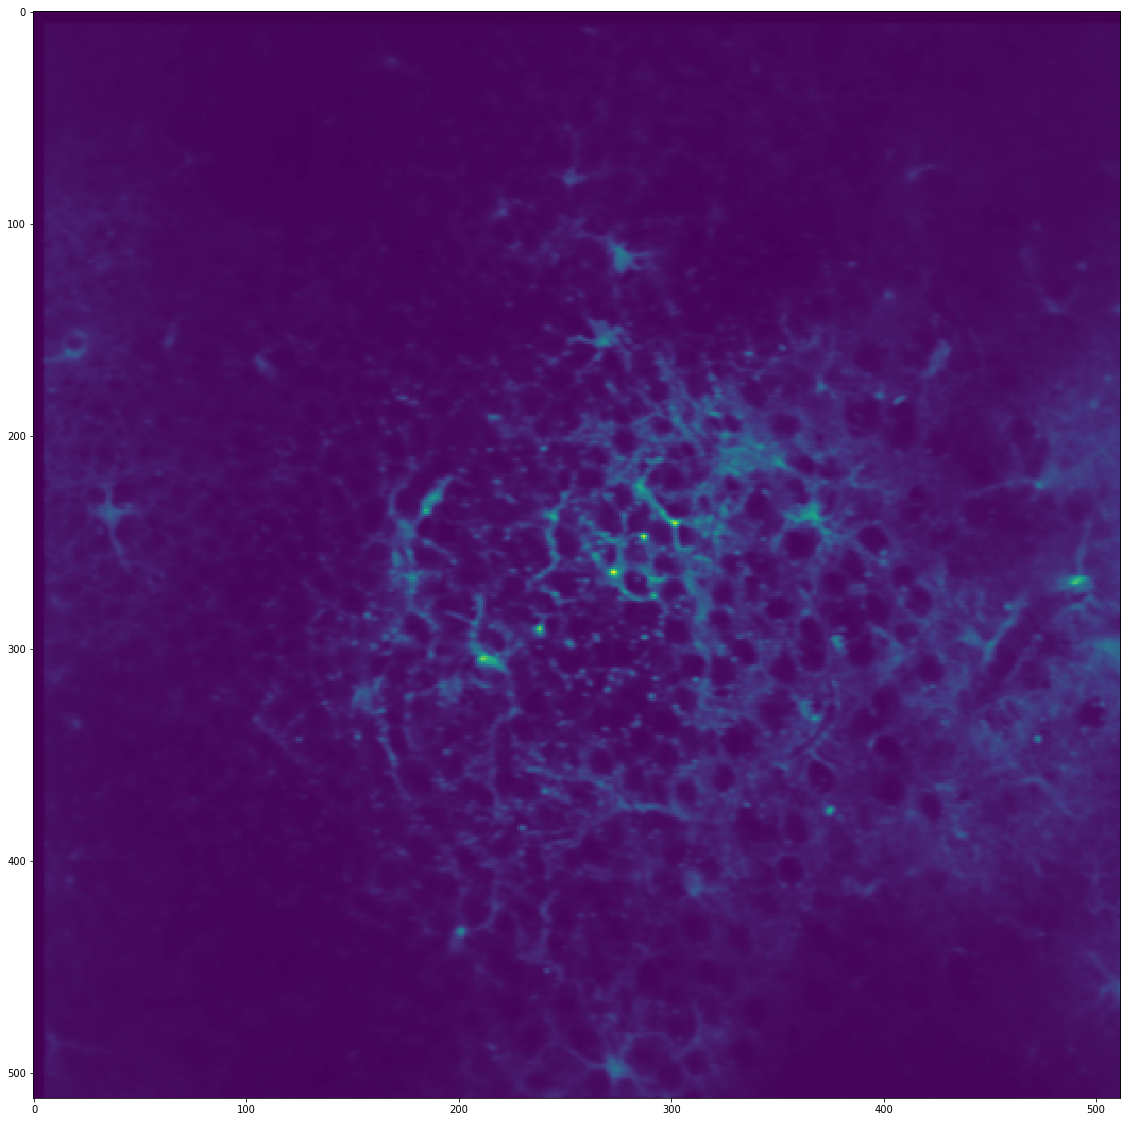

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(dict_im['Enhanced_007'])

In [20]:
dict_im.keys()

dict_keys(['Astro_domain_radius', 'Active Regions_007', 'Enhanced_007', 'Prob. Map PL_007', 'Prob. Map_007', 'Final_Mask_007', 'Single_cell_mask_007', 'Cell_num_007', 'Signals_extr_007', 'ROI_007', 'crop_coord_ROI_007', 'shift_ROI_007', 'Final_Mask_fraction_007', 't-series_007', 'Num_CC_007'])

In [6]:
cell = [0,1,2,4,5]

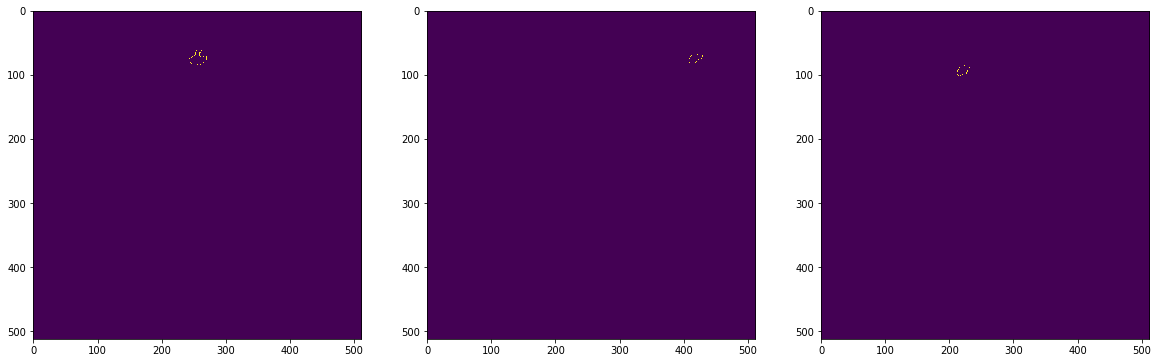

In [7]:
fig,[ax1,ax2,ax3] =plt.subplots(figsize=(20,20),ncols=3,nrows=1)
for j,a in zip(cell,[ax1,ax2,ax3]):
    a.imshow(mask_ROI[j,:,:,2])

# Dislpay

In [9]:
fov_name = []
for j in [2]:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name


['002']

In [10]:
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

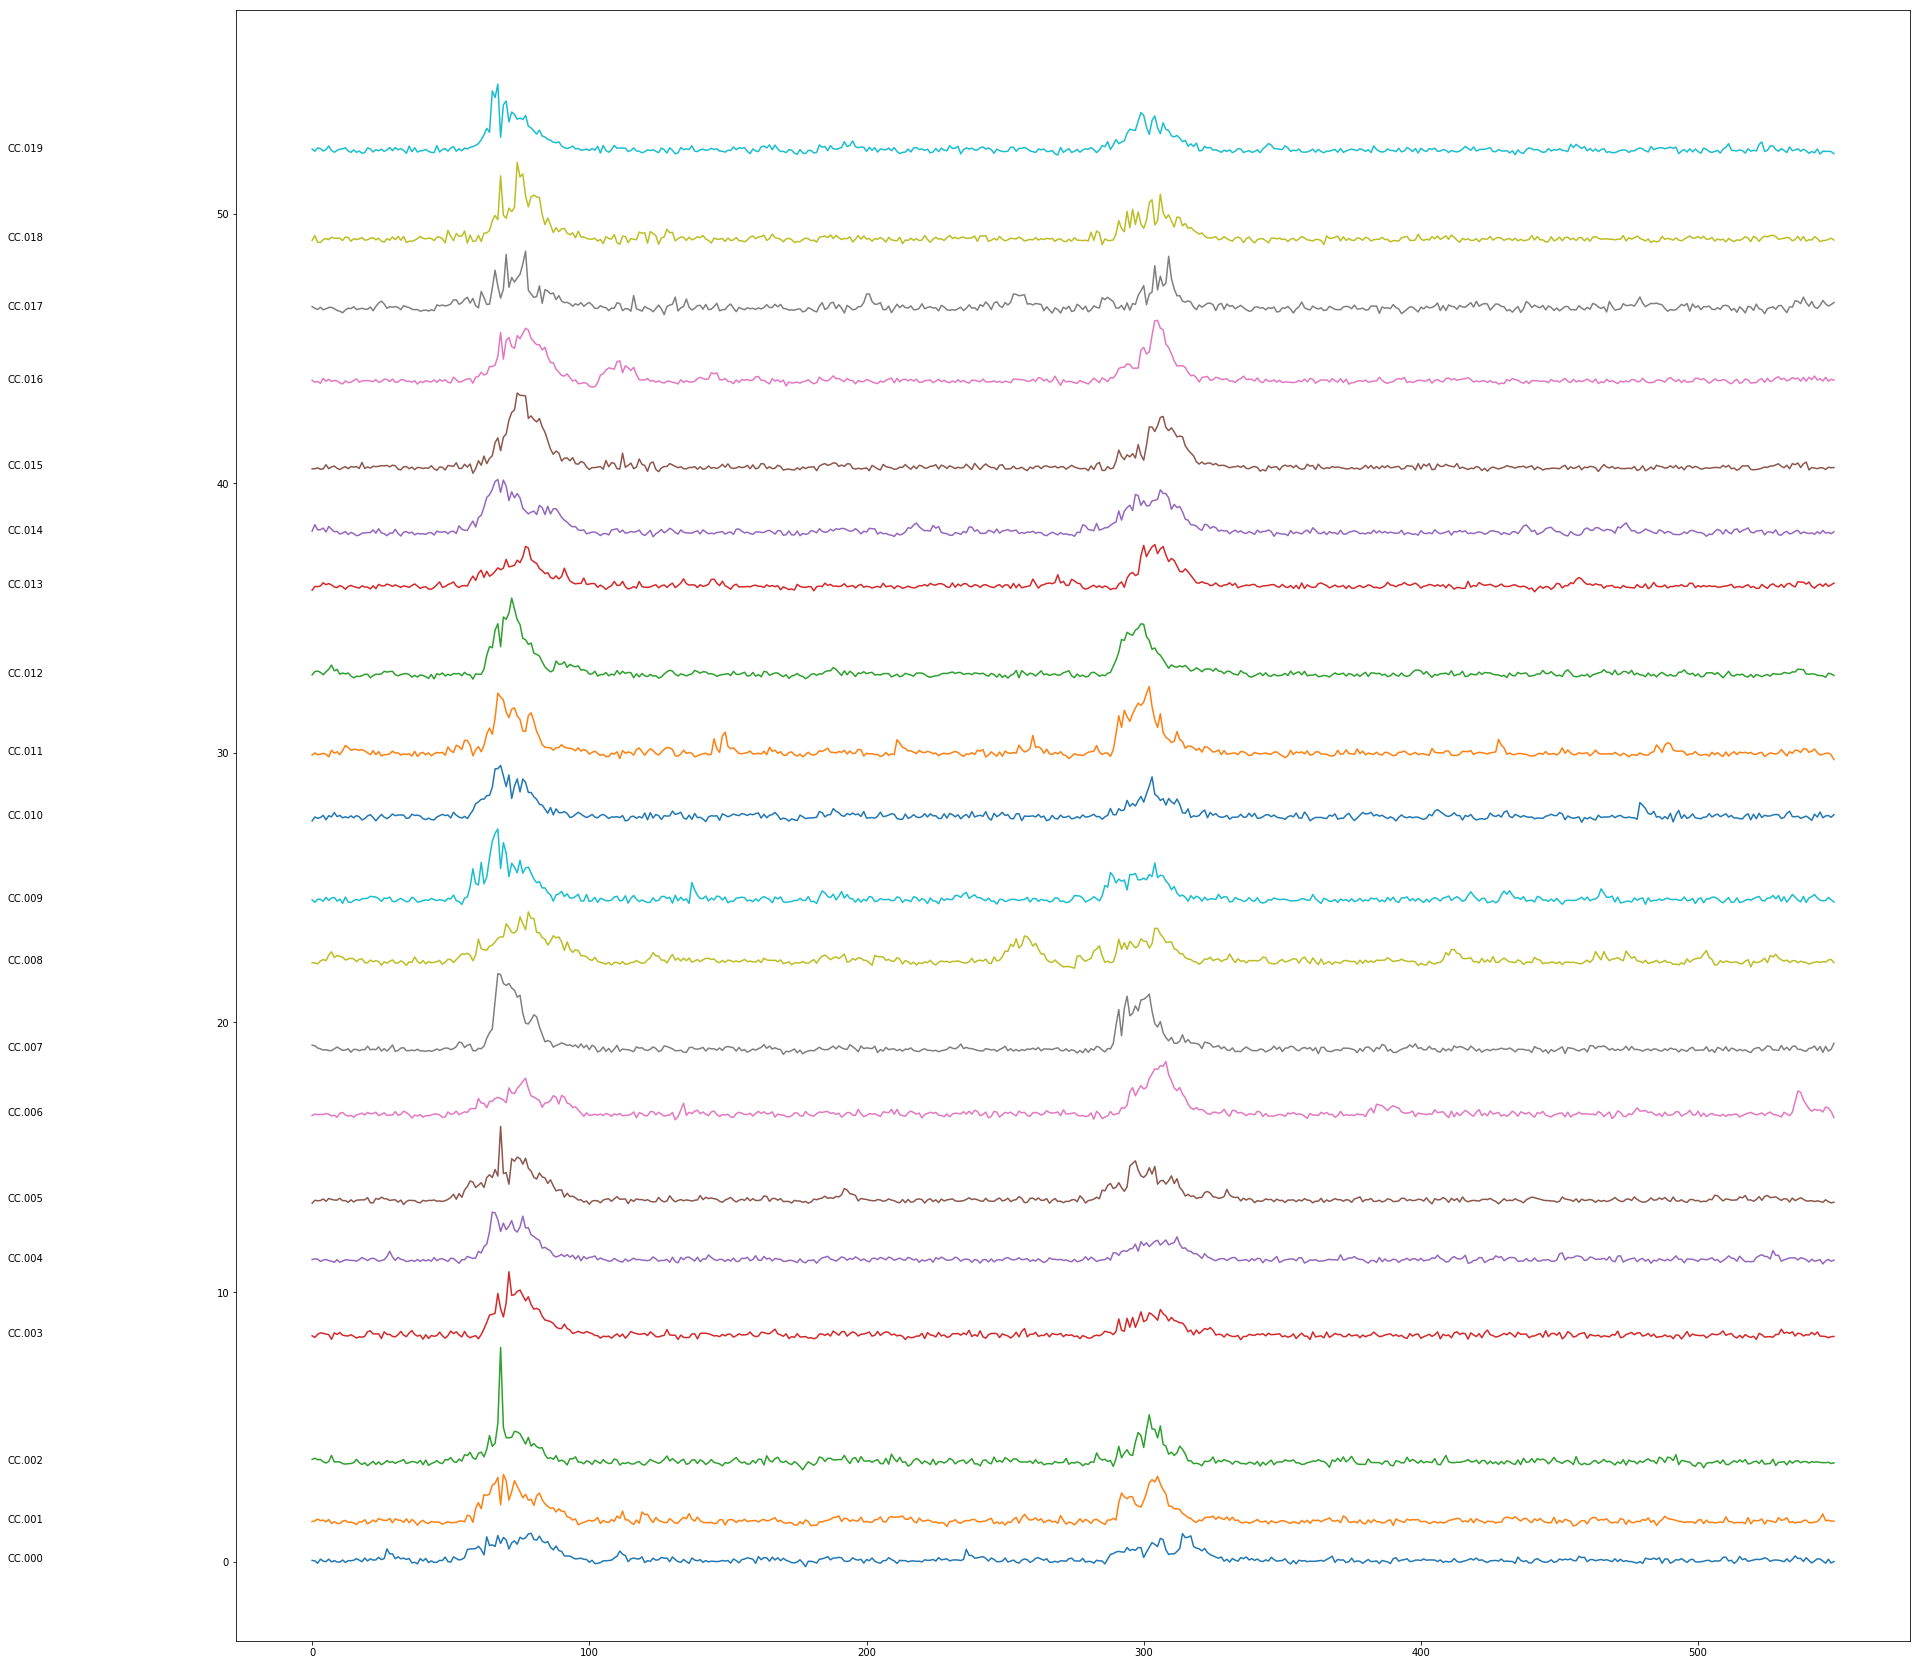

In [27]:
def plot_traces(dict_,cell_num,window,ax):
    MAX_traces=20
    
    traces = []
    name=[]
    cnt=0
    for key in dict_.keys():
        if 'CC_'+f'{str(cell_num):0>3}'+'_' in key and cnt<= MAX_traces:
            traces.append(dict_[key])
            name.append('CC.'+str(key[-3:]))
            cnt+=1
    traces = np.asarray(traces)
    #print(traces.shape)
    f0 = get_f0(traces,window)
    traces = (traces-f0)/(f0+0.0001)
    delta = 0
    for j in range(np.minimum(traces.shape[0],MAX_traces)):
        if np.max(traces[j,:])>100 or np.max(traces[j,:])==np.nan:
            traces[j,:]=0
            ax.plot(np.arange(traces.shape[1]),traces[j,:]+delta)
            ax.text(x = -traces.shape[1]/5, y= 0+delta, s =name[j] , rotation = 0,fontsize= 10)
            delta+= traces[j,:].max()+1
        else:
            ax.plot(np.arange(traces.shape[1]),traces[j,:]+delta)
            ax.text(x = -traces.shape[1]/5, y= 0+delta, s =name[j] , rotation = 0,fontsize= 10)
            delta+= traces[j,:].max()+0.4
            
def get_f0(traces,window):
    baseline = np.zeros_like(traces).astype(np.float32)
    for i in range(traces.shape[1]):
        if i<window:
            st=0
        else:
            st=i-window
        if i>traces.shape[1]-window:
            end = -1
        else:
            end=i+window

        baseline[:,i] = np.percentile(traces[:,st:end],20,axis=1)

    return baseline          

fig,ax = plt.subplots(figsize=(30,30),ncols=1,nrows=1)
plot_traces(dict_im['Signals_extr_'+query],1,20,ax)